# Convolution setting up

## Functions definition

In [28]:
# Function taking the interval [a, b] where some (b-a)-periodic function is defined and returns x shifted into this interval
function center_arg(a,b,x)
    M = floor((x-a)/(b-a))
    x -= M*(b-a)
    return x
end

center_arg (generic function with 1 method)

In [29]:
# Defining book's kernel function

function f(x)
    # Scaling the input argument to get a periodic function
    x = center_arg(0, 1, x)
    if 0.1<=x<=0.2
        return 5x-0.5
    elseif 0.2<x<=0.3
        return -5x+1.5
    elseif 0.5<x<=0.6
        return 1 
    elseif 0.6<x<0.7
        return 0.2 
    elseif 0.7<=x<=0.8
        return 1.3
    else 
        return 0
    end
end

f (generic function with 1 method)

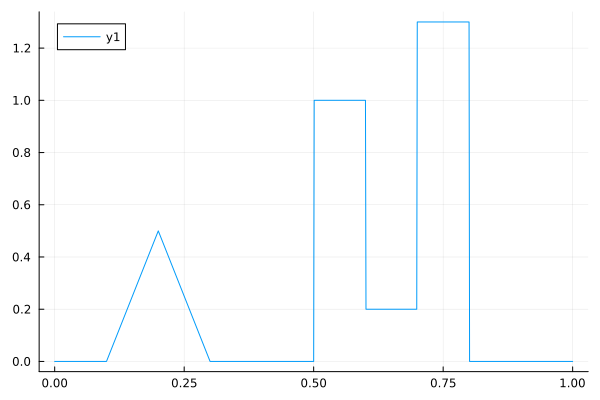

1001


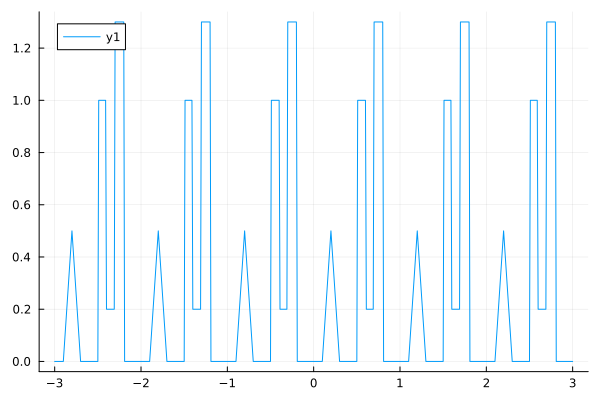

In [30]:
using Plots

dx = 0.001
X = 0:dx:1
N = length(X)
println(N)

# Plotting kernel on [0,1] then on [-3,3] to see the periodicity
display(plot(X, f.(X)))
plot(-3:0.01:3, f.(-3:0.01:3))

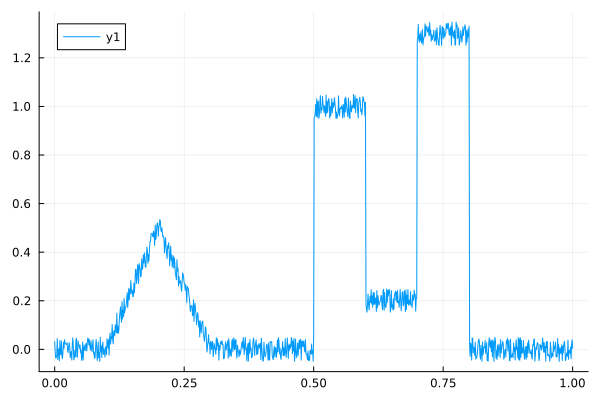

In [31]:
## Introducing noise
σ = 0.1 # noise level
noise(x) = (rand()-0.5)*σ # uniform noise in [-σ/2, σ/2]
f_noise(x) = f(x) + noise(x)
plot(X, f_noise.(X))


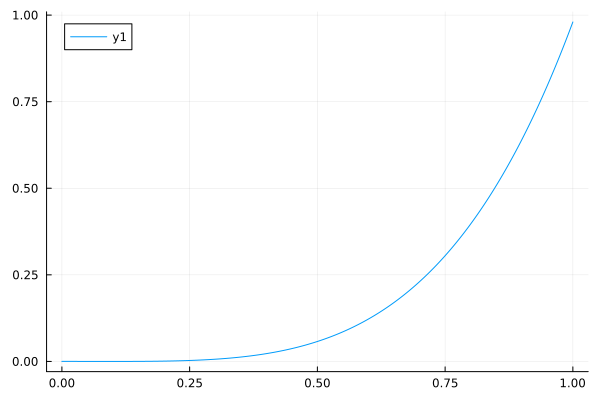

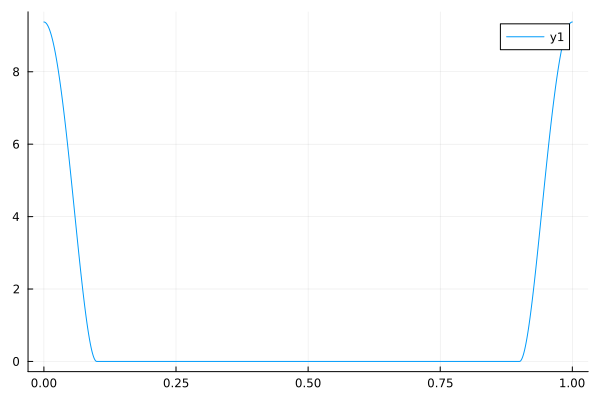

1.066666666666667e-5


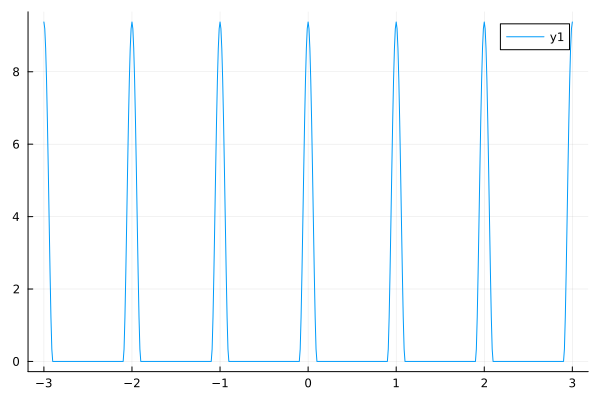

In [32]:
using QuadGK

# Point spread function (PSF)
a = 0.1
p(x) = (x+a)^2*(x-a)^2
C,_ = quadgk(p,-a,a) 
println(C)

function psf(x,a)
    x = center_arg(-.5, .5, x)
    # a > 0
    res = 0
    if -a <= x <= a
        res = (p(x)/C)
    end
    return res
end

# Plotting PSF generation function, then the PSF itself
display(plot(X, p.(X)))
display(plot(X, psf.(X,a)))
plot(-3:0.01:3, psf.(-3:0.01:3, a))


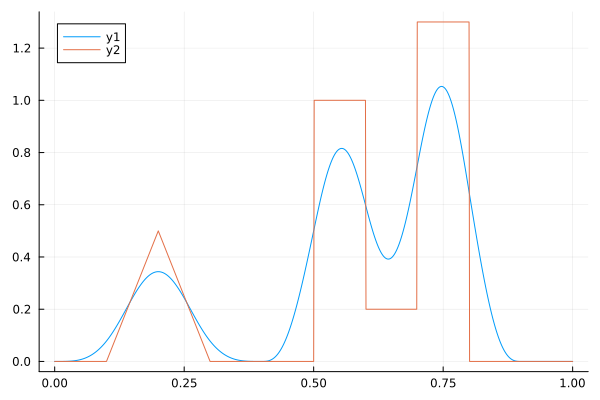

In [33]:
# Convolution
function convolved(s)
    K(t) = f(s-t) * psf(t,a)
    res, _ = quadgk(K, -a, a)
    return(res)
end

plot(X, [convolved.(X),f.(X)])

# Chapter 1 & 2

## Naïve reconstruction

#### Naïve reconstruction

In [34]:
A = zeros(N,N)
ν = floor(Int, a/dx)
P = psf.((-ν:ν)*dx,a)
for i in 1:N
    for j in -ν:ν
        A[i,1+mod(i+j-1,N)] = dx * P[ν+1-j]
    end
end
println(ν)
println(P)
println(P[ν+1])
A

100
[0.0, 0.003712593750000006, 0.014701500000000024, 0.032745093750000044, 0.05762400000000009, 0.08912109375000013, 0.12702150000000018, 0.17111259375000026, 0.22118400000000035, 0.27702759375000036, 0.3384375000000005, 0.4052100937500006, 0.4771440000000006, 0.5540400937500009, 0.6357015000000009, 0.7219335937499997, 0.8125439999999996, 0.9073425937499997, 1.0061414999999998, 1.1087550937499997, 1.215, 1.3246950937500002, 1.4376615000000001, 1.55372259375, 1.6727040000000002, 1.7944335937500002, 1.9187415000000005, 2.045460093750001, 2.1744240000000006, 2.305470093750001, 2.4384374999999996, 2.573167593749999, 2.709503999999999, 2.8472925937499998, 2.9863815, 3.1266210937499994, 3.267864, 3.40996509375, 3.5527814999999996, 3.69617259375, 3.8400000000000007, 3.9841275937500003, 4.128421499999999, 4.272750093749999, 4.416983999999999, 4.560996093749999, 4.7046615, 4.847857593749999, 4.990463999999999, 5.13236259375, 5.2734375, 5.4135750937500005, 5.552664000000001, 5.690595093750001, 

1001×1001 Matrix{Float64}:
 0.009375    0.00937313  0.0093675   …  0.00935813  0.0093675   0.00937313
 0.00937313  0.009375    0.00937313     0.00934502  0.00935813  0.0093675
 0.0093675   0.00937313  0.009375       0.00932818  0.00934502  0.00935813
 0.00935813  0.0093675   0.00937313     0.00930762  0.00932818  0.00934502
 0.00934502  0.00935813  0.0093675      0.00928335  0.00930762  0.00932818
 0.00932818  0.00934502  0.00935813  …  0.00925538  0.00928335  0.00930762
 0.00930762  0.00932818  0.00934502     0.00922374  0.00925538  0.00928335
 0.00928335  0.00930762  0.00932818     0.00918844  0.00922374  0.00925538
 0.00925538  0.00928335  0.00930762     0.0091495   0.00918844  0.00922374
 0.00922374  0.00925538  0.00928335     0.00910694  0.0091495   0.00918844
 ⋮                                   ⋱                          ⋮
 0.00922374  0.00918844  0.0091495      0.00930762  0.00928335  0.00925538
 0.00925538  0.00922374  0.00918844     0.00932818  0.00930762  0.00928335
 0.00928

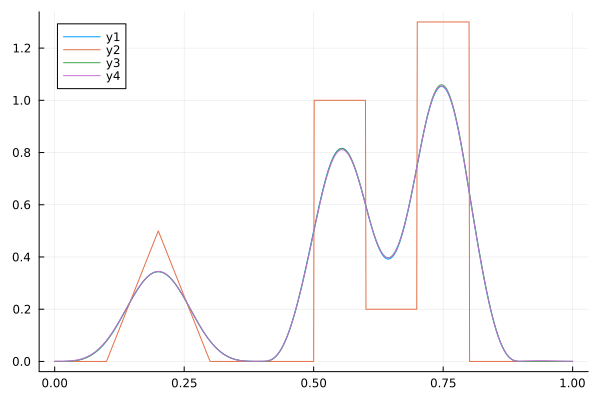

In [35]:
# Approximation of f
convolved_scat = A * f.(X)
convolved_scat_noise = A * f_noise.(X)

plot(X, [convolved.(X),f.(X), convolved_scat, convolved_scat_noise])


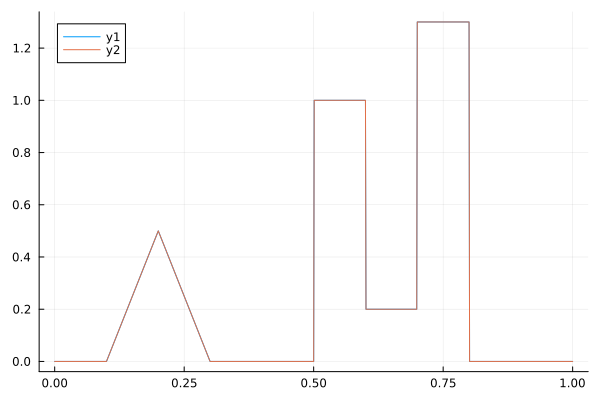

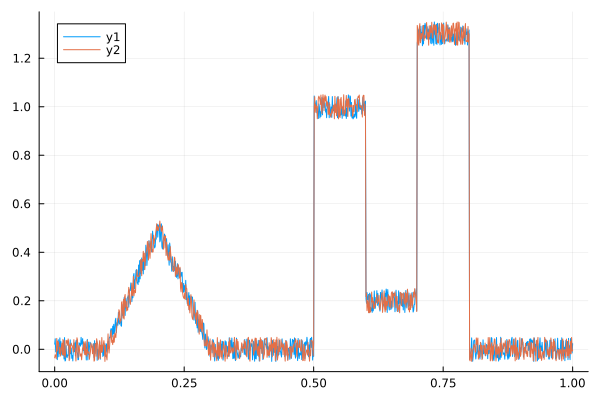

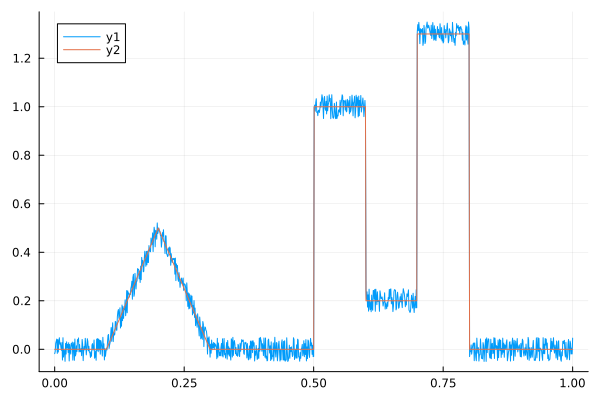

In [36]:
f_inverse = A^-1 * convolved_scat
f_noise_inverse = A^-1 * convolved_scat_noise
f_inverse_noised = A^-1 * convolved_scat + noise.(X)

display(plot(X, [f_inverse, f.(X)]))
display(plot(X, [f_noise_inverse, f_noise.(X)]))
plot(X, [f_inverse_noised, f.(X)])

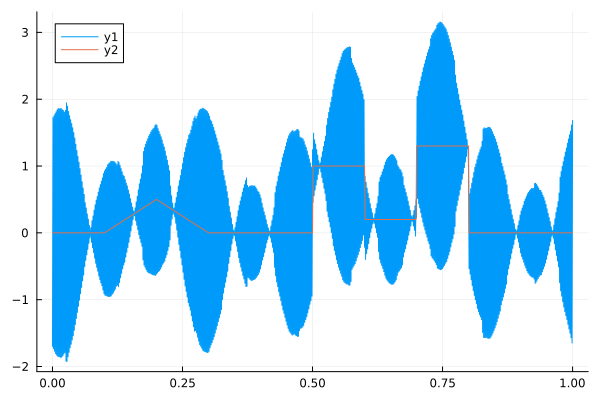

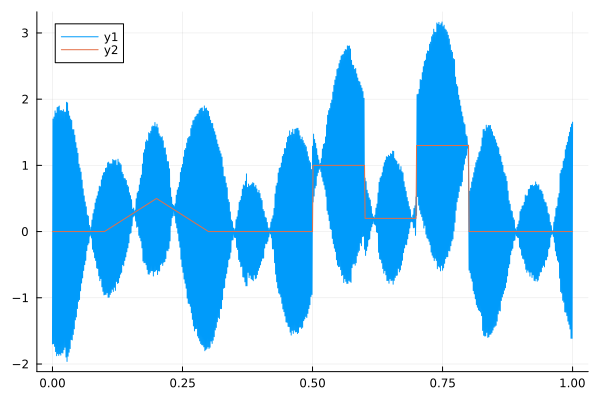

In [37]:
f_inverse_realconvol = A^-1 * convolved.(X)
f_inverse_noised_realconvol = A^-1 * convolved.(X) + noise.(X)

display(plot(X, [f_inverse_realconvol, f.(X)]))
plot(X, [f_inverse_noised_realconvol, f.(X)])

# Chapters 3 and 4

## Noise robustness 

Exercise 4.4.2 example

Conditionnement : 1.0397216253729281e9


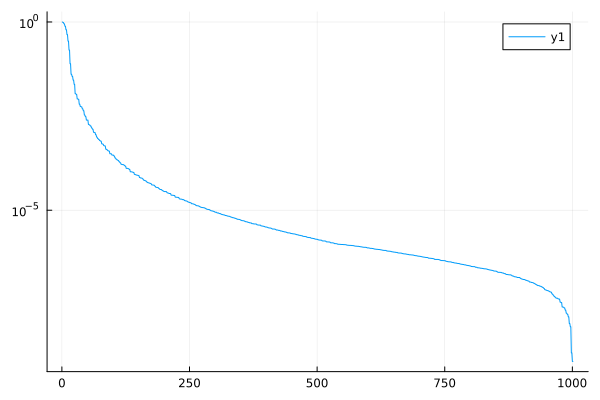

In [38]:
using LinearAlgebra

A_svd = svd(A)
D = A_svd.S
println("Conditionnement : ", maximum(D)/minimum(D))
# Plotting the singular values in decreasing order
plot(D, yaxis=:log)


In [39]:
# Defining TSVD Regularization matrices

function D⁺(D,α)
    n = length(D)
    D⁺ = zeros(n)
    for i = 1:n
        if D[i] > α
            D⁺[i] = 1/D[i]
        end
    end
    return D⁺
end

function D_TSVD(D, n_sval)
    n = length(D)
    res = zeros(n)
    for i = 1:n_sval
        res[i] = 1/D[i]
    end
    return res
end


D_TSVD (generic function with 1 method)

In [40]:
# One can define the Regularization matrix by either choosing the threshold on singular value α or by choosing the trucation index n_sval
α = 1e-3
n_sval = 200
#inv = A_svd.V * Diagonal(D⁺(A_svd.S, α)) * A_svd.U'
inv = A_svd.V * Diagonal(D_TSVD(A_svd.S, n_sval)) * A_svd.U'

1001×1001 Matrix{Float64}:
  17.9164    21.6196    17.8863    …    -3.44183    -2.11809    7.74388
  21.6196    -1.1777   -19.7837         29.5084     39.05      36.9804
  17.8863   -19.7837   -41.774          57.2993     68.607     52.9257
  11.5224   -22.71     -36.9072         62.4481     71.1751    49.5129
   8.91657   -5.60113   -6.80028        36.7183     43.354     29.7717
  12.6482    24.8263    34.459     …   -13.2701     -4.68509    2.7577
  18.6674    52.7084    66.6705        -67.6742    -53.8664   -21.8086
  18.2516    60.5116    72.9742       -102.099     -84.7977   -37.9567
   3.88755   38.5175    47.8843        -99.3551    -86.189    -44.7375
 -24.4717    -8.73982    0.046963      -58.4803    -59.2949   -44.3448
   ⋮                               ⋱                            ⋮
 -35.9217   -41.2161   -43.3343          0.380554  -16.8117   -28.3757
   7.01624  -28.777    -66.3077         17.645      28.2484    27.0675
  34.2121   -18.0754   -72.0958         34.4072     61

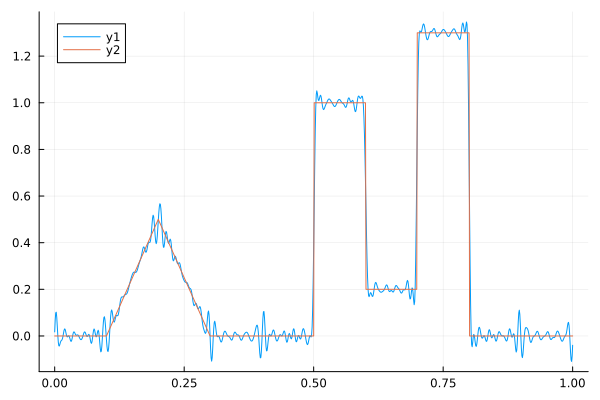

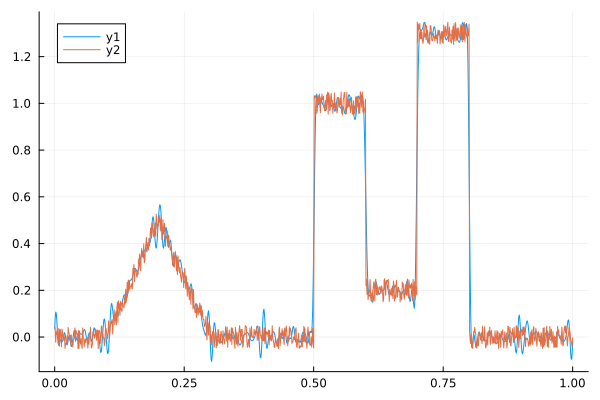

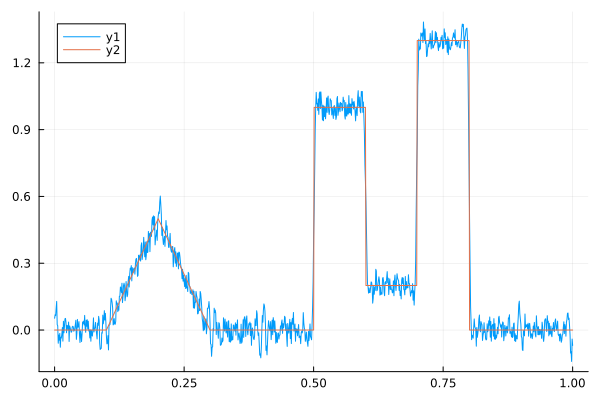

In [41]:
f_inverse = inv * convolved_scat
f_noise_inverse = inv * convolved_scat_noise
f_inverse_noised = inv * convolved_scat + noise.(X)

display(plot(X, [f_inverse, f.(X)]))
display(plot(X, [f_noise_inverse, f_noise.(X)]))
plot(X, [f_inverse_noised, f.(X)])

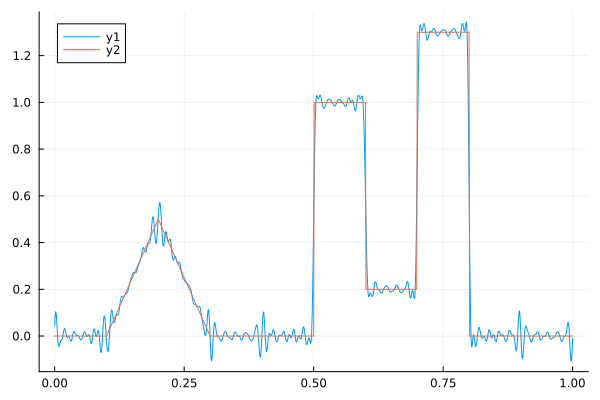

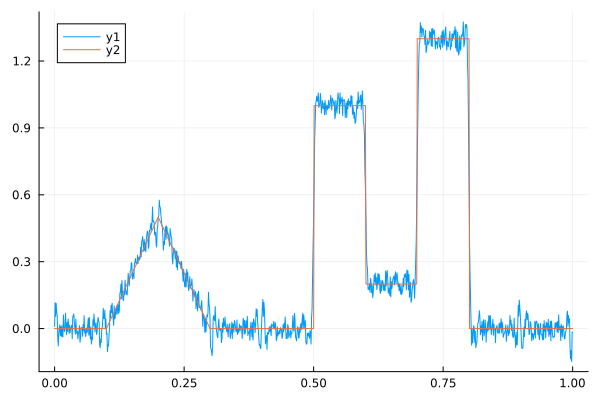

In [42]:
f_inverse_realconvol = inv * convolved.(X)
f_inverse_noised_realconvol = inv * convolved.(X) + noise.(X)

display(plot(X, [f_inverse_realconvol, f.(X)]))
plot(X, [f_inverse_noised_realconvol, f.(X)])

# Chapter 6 :  Total variation Regularization

### Exercice 6.6.1

Norm 1 and 2 of Lof : [80.0, 391.5478696387713]
Norm 1 and 2 of Loh : [80.0, 1600.0]


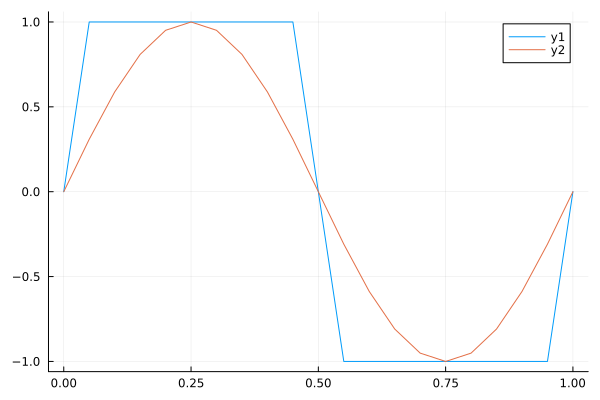

In [43]:
using Plots

stp = 1/20
rng = 0:stp:1
function h(x)
    res = 0.
    if 0 < x < 0.5
        res = 1.
    elseif 0.5 < x < 1
        res = -1.
    end
    return res
end
wv(x) = sin(2 * π * x)

norm1(Z, step) = sum(abs.(Z[2:end]-Z[1:end-1])/step)
norm2(Z,step)= sum((abs.(Z[2:end]-Z[1:end-1])/step).^2)

# Comparison of the different norms
println("Norm 1 and 2 of Lof : ", [norm1(wv.(rng), stp), norm2(wv.(rng), stp)])
println("Norm 1 and 2 of Loh : ", [norm1(h.(rng), stp), norm2(h.(rng), stp)])


plot(rng, [h.(rng), wv.(rng)])

In [44]:
function L(ds,n)
    res = zeros(n,n)
    for i in 1:n-1
        for j in i:i+1
            res[i,j] = i==j ? 1 : -1
        end
    end
    res[n,n] = 1
    res[n,1] = -1
    return 1/ds * res            
end

# Lmat = L(1/10,10)

L (generic function with 1 method)

In [53]:
using JuMP, Clarabel, SparseArrays

function totalVar(A, m, α, ds)
    n = size(A,2)
    Lmat = L(ds, n)
    H = zeros(3n, 3n)
    H[1:n, 1:n] = 2*A'*A
    h = vcat(- 2*A'*m, α * ones(n), α * ones(n))

    Eq = hcat(Lmat, -I(n), I(n))
    b = zeros(n)

    model = Model(Clarabel.Optimizer)
    @variable(model, y[1:3n] >= 0)
    @variable(model, t[1:1])
    @constraint(model, [t[1]; h + H * y] in SecondOrderCone())
    # @constraint(model, [t[2]; Lmat*y[1:n]] in FirstOrderCone())
    @constraint(model, y[n+1:3n] .>= 0) # Non-negativity constraint
    @constraint(model, Eq*y == b) # Equality constraint
    @objective(model, Min, t[1]) # + α * t[2]) --- IGNORE ---
    optimize!(model)
    @assert is_solved_and_feasible(model)
    return value.(y[1:n])
end

αs = [0.005, 0.05, 0.1, 1, 10]
f_TVs = []
for α in αs
    println("Solving for α = $α")
    push!(f_TVs,totalVar(A,convolved_scat, α, 0.001))
end
print("solved")


Solving for α = 0.005
-------------------------------------------------------------
           Clarabel.jl v0.7.1  -  Clever Acronym              
                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 3004
  constraints   = 9010
  nnz(P)        = 0
  nnz(A)        = 406407
  cones (total) = 4
    : Zero        = 1,  numel = 1001
    : Nonnegative = 2,  numel = (3003,2002)
    : SecondOrder = 1,  numel = 3004

settings:
  linear algebra: direct / qdldl, precision: Float64
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-08, tol_gap_abs = 1.0e-08, tol_gap_rel = 1.0e-08,
  static reg : on, ϵ1 = 1.0e-08, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-07
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12, 
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-05, max_scale

AssertionError: AssertionError: is_solved_and_feasible(model)

["α = 0.005", "α = 0.05", "α = 0.1", "α = 1.0", "f"]

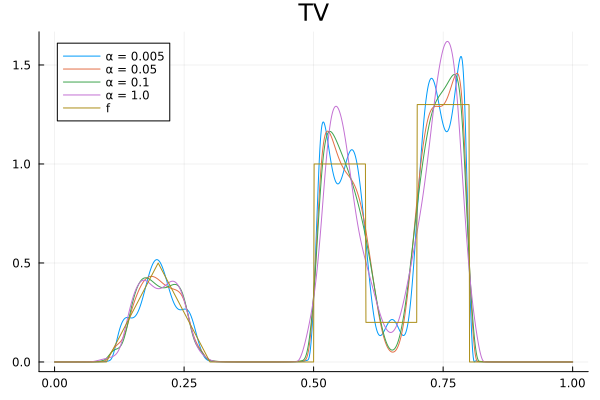

In [ ]:
legend = vcat(["α = "*string(α) for α in αs[1:end-1]], ["f"])
plot(X, [f_TVs, f.(X)], plot_title="TV", lab=permutedims(legend))

# Chapter 7 : Besov Space